In [1]:
import copy
import os.path
import torch
import torch.functional as F
import math
import logging
import numpy as np
import PIL.Image    
import exiftool
import cv2
import ultralytics
from shapely.geometry import Polygon
from flat_bug.ml_utils import iou_match_pairs, iou
from flat_bug.geometry_simples import contours_to_masks
from ultralytics import YOLO
from ultralytics.nn.tasks import SegmentationModel
from ultralytics.nn.autobackend import AutoBackend
from ultralytics.models.yolo.segment import SegmentationPredictor
from ultralytics.engine.results import Results
from ultralytics.utils import ops

from torchvision.io import read_image
import torchvision.transforms as transforms

from tqdm import tqdm

import logging
import os
from flat_bug.predictor import Predictor
from pyremotedata.implicit_mount import *
from pyremotedata.dataloader import *

import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools

from src.flat_bug.predictor import *
from src.flat_bug.yolo_helpers import *

In [4]:
# image_basename = "20220820030000-113-snapshot.jpg"
# image_basename = "20230630001000-59-snapshot.jpg"
# image_basename = "original_20220730023959-130-snapshot.jpg"
# image_basename = "20220723025959-17-snapshot.jpg"
image_basename = "20220721024000-16-snapshot.jpg"

path = f"dev/input/{image_basename}"

weights = "best.pt"
device = torch.device("cuda:0")
dtype = torch.float16

image = read_image(path).to(device, dtype)
# image = resize(image)
resize = transforms.Resize((1024, 1024))

_model = Predictor(weights, device=device, dtype=dtype)
_model.MINIMUM_TILE_OVERLAP = 768
_model.SCORE_THRESHOLD = 0.05
_model.MAX_MASK_SIZE = 2048
_model.IOU_THRESHOLD = .99
_model.MIN_MAX_OBJ_SIZE = 1, 2048
_model.TIME = True

Transferred 537/537 items from pretrained weights


In [5]:
n = 1
start = time.time()
for _ in range(n):
    test = _model.pyramid_predictions(image, path, scale_increment=3/4, scale_before=1/2)
    test.save("dev/output", fast=True, mask_crops=True)
print(f'Average time: {(time.time() - start) / n:.3f}s')

Prediction time: 8.860s/98.8% (overhead: 0.0) | Fetch 0.0% | Forward 9.9% | Postprocess 90.1%
Total detection time: 8.963s (9.77% forward)
Combining 1 predictions into a single TensorPredictions object took 0.100 s | Duplication removal: 0.099 s | Mask combination: 0.001 s
Initializing TensorPredictions took 0.100 s
Non-maximum suppression took 0.706 s for removing 0 elements of 216 elements
Offsetting, scaling and padding took 0.001 s
Total pyramid time: 9.775s (91.7% detection | 8.96% forward)
Average time: 11.138s


In [15]:
test_loaded = TensorPredictions().load("test/original_20220730023959-130-snapshot/original_20220730023959-130-snapshot.json")
test_loaded.image = test.image

# test_loaded.plot_torch(outpath="test/test.jpg", linewidth=1, scale=1/2)
test_loaded.plot_opencv(outpath="test/test_loaded.jpg", linewidth=2, scale=1)
test.plot_opencv(outpath="test/test.jpg", linewidth=2, scale=1)

Text(0.5, 1.0, 'IoS * IoU')

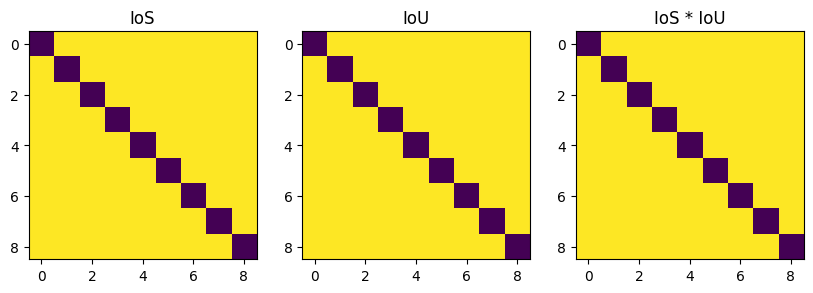

In [6]:
from flat_bug.yolo_helpers import ios_masks_2sets, iou_masks_2sets, nms_masks

ios_mat = torch.cat([ios_masks_2sets(m, test.masks.data, dtype=dtype) for m in test.masks.data])
iou_mat = torch.cat([iou_masks_2sets(m, test.masks.data, dtype=dtype) for m in test.masks.data])

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow((ios_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[0].set_title("IoS")
axs[1].imshow((iou_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[1].set_title("IoU")
axs[2].imshow((ios_mat * iou_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[2].set_title("IoS * IoU")

In [ ]:
def expand_with_neighbors(indices, mx, my):
    # Initialize a list to store the expanded indices
    expanded_indices = []

    # Define the relative positions of the neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Iterate over each index pair and add its neighbors
    for x, y in indices:
        for dx, dy in neighbors:
            new_x, new_y = x + dx, y + dy
            new_x = min(max(new_x, 0), mx)
            new_y = min(max(new_y, 0), my)
            expanded_indices.append([new_x, new_y])

    # Convert the list of indices to a numpy array
    return np.array(expanded_indices)


In [ ]:
plt.figure(figsize=(10, 10))
ms = np.zeros(image.shape[1:]) # CxHxW
boxes = test._bboxes # x, y, w, h
print(ms.shape)
xys = np.concatenate(test.contours)
msx, msy = ms.shape
xys = expand_with_neighbors(expand_with_neighbors(xys, msy - 1, msx - 1), msy - 1, msx - 1)
ms[xys[:, 1], xys[:, 0]] = 1
# Permute to HxWxC (numpy)
# ms = ms.transpose(1, 2, 0)
plt.imshow(image.cpu().int().permute(1, 2, 0))
# plt.imshow(ms, alpha = .75)
for x, y, w, h in boxes:
    plt.gca().add_patch(mpl.patches.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=1))
plt.show()

In [ ]:
def intersect_test(rect1, rect2s, area_only=False, debug=False):
    """
    Calculates the intersection of a rectangle with a set of rectangles.
    """
    if len(rect1.shape) == 1 and not rect1.shape[0] == 4 or len(rect1.shape) == 2 and not rect1.shape[1] == 4:
        raise ValueError(f"Rectangles must be of shape (n, 4), not {rect1.shape}")
    if len(rect2s.shape) == 1 and not rect2s.shape[0] == 4 or len(rect2s.shape) == 2 and not rect2s.shape[1] == 4:
        raise ValueError(f"Rectangles must be of shape (n, 4), not {rect2s.shape}")
    if len(rect1.shape) == 1:
        rect1 = rect1.unsqueeze(0)
    if len(rect2s.shape) == 1:
        rect2s = rect2s.unsqueeze(0)

    # Safer to enable this, but it is slower
    # # Check the validity of the rectangles
    # if not check_bltr_validity(rect1, debug):
    #     rect1 = fix2btlr(rect1)
    # if not check_bltr_validity(rect2s, debug):
    #     rect2s = fix2btlr(rect2s)

    # Calculate vectors from each corner of rect1 to each corner of rect2s
    blbltrtr = rect2s - rect1
    bl_to_bl = blbltrtr[:, :2]
    tr_to_tr = blbltrtr[:, 2:] 
    bltrtrbl = rect2s[:, [2, 3, 0, 1]] - rect1
    bl_to_tr = bltrtrbl[:, :2]
    tr_to_bl = bltrtrbl[:, 2:]
    
    # Determine if each corner of rect1 is inside each rect2
    inside_tr = (tr_to_tr[:, 0] >= 0) & (tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 0] <= 0) & (tr_to_bl[:, 1] <= 0)
    inside_bl = (bl_to_bl[:, 0] <= 0) & (bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 0] >= 0) & (bl_to_tr[:, 1] >= 0)
    inside_tl = (bl_to_bl[:, 0] <= 0) & (tr_to_tr[:, 1] >= 0) & (bl_to_tr[:, 0] >= 0) & (tr_to_bl[:, 1] <= 0)
    inside_br = (tr_to_tr[:, 0] >= 0) & (bl_to_bl[:, 1] <= 0) & (tr_to_bl[:, 0] <= 0) & (bl_to_tr[:, 1] >= 0)

    # Check for enclosure
    enclosure = (rect1[:, :2] <= rect2s[:, :2]) & (rect1[:, 2:] >= rect2s[:, 2:])

    # Check for intersection with the "infinitely" extended cross of rect1
    in_cross = ((bl_to_bl[:, 0] <= 0) & (bl_to_tr[:, 0] >= 0)) | ((tr_to_tr[:, 0] >= 0) & (tr_to_bl[:, 0] <= 0)), ((bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 1] >= 0)) | ((tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 1] <= 0))

    # Check for equality - if equal, return the original rectangles
    zero = torch.tensor(0, dtype=rect1.dtype, device=rect1.device)
    is_equal = (bl_to_bl.isclose(zero).all(dim=1)) & (tr_to_tr.isclose(zero).all(dim=1))

    # Check for no intersection - if no intersection, return the intersection rectangle [0, 0, 0, 0]
    is_intersecting = inside_tl | inside_br | inside_bl | inside_tr | (enclosure[:, 0] & in_cross[1]) | (enclosure[:, 1] & in_cross[0]) | (enclosure[:, 0] & enclosure[:, 1]) | is_equal

    if not area_only:
        intersections = is_intersecting.unsqueeze(1) * torch.cat((torch.max(rect1[:, :2], rect2s[:, :2]), torch.min(rect1[:, 2:], rect2s[:, 2:])), dim=1)
        intersections[is_equal] = rect1
    else:
        intersections = torch.zeros(rect2s.shape[0], dtype=rect1.dtype, device=rect1.device)
        intersections[is_intersecting] = (torch.min(rect1[:, 2:], rect2s[is_intersecting, 2:]) - torch.max(rect1[:, :2], rect2s[is_intersecting, :2])).abs().prod(dim=1)

    if debug:
        # Used for debugging
        return intersections, torch.stack((inside_tl, inside_tr, inside_br, inside_bl), dim=1), enclosure, in_cross
    else:
        return intersections

In [ ]:
# Example usage
r2 = torch.tensor([2, 2, 5, 5], dtype=dtype, device=device)  # Rectangle 2 coordinates

xmins = [1, 2, 3]
ymins = [1, 2, 3]
xmaxs = [4, 5, 6]
ymaxs = [4, 5, 6]

n_rects = len(xmins) * len(ymins) * len(xmaxs) * len(ymaxs)
ncols = min(6, int(n_rects ** (1/2)))
nrows = math.ceil(n_rects / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))

rectangles = []

for xmin, ymin, xmax, ymax in itertools.product(xmins, ymins, xmaxs, ymaxs):
    r11 = torch.tensor([xmin, ymin, xmax, ymax], dtype=dtype, device=device)
    rectangles.append(r11.clone())

rectangles = torch.stack(rectangles)
rectangles = fix2btlr(rectangles)

intersections, corners, encs, crs = intersect_test(r2.unsqueeze(0), rectangles, debug=True)

# Move tensors to cpu and convert to float
rectangles = rectangles.detach().float().cpu().numpy()
intersections = intersections.detach().float().cpu().numpy()
corners = corners.detach().cpu()
encs = encs.detach().cpu()
crs = torch.stack(crs, dim=1).detach().cpu()
r2 = r2.detach().float().cpu().numpy()

for i, (ax, r1, inter) in enumerate(zip(axs.flatten(), rectangles, intersections)):
    # IOU
    a1 = (r1[2] - r1[0]) * (r1[3] - r1[1])
    a2 = (r2[2] - r2[0]) * (r2[3] - r2[1])
    ai = (inter[2] - inter[0]) * (inter[3] - inter[1])
    iou = ai / (a1 + a2 - ai)

    # Plot rect1
    p1 = mpl.patches.Rectangle((r1[0], r1[1]), r1[2] - r1[0], r1[3] - r1[1], linewidth=3, edgecolor="r", facecolor="none", alpha=1)
    # Plot rect2
    p2 = mpl.patches.Rectangle((r2[0], r2[1]), r2[2] - r2[0], r2[3] - r2[1], linewidth=3, edgecolor="b", facecolor="none", alpha=1)

    # Plot the intersection
    if inter.sum() > 0:
        p3 = mpl.patches.Rectangle((inter[0], inter[1]), inter[2] - inter[0], inter[3] - inter[1], linewidth=0, edgecolor="none", facecolor="g", alpha=0.5)
        ax.add_patch(p3)
        icenter = (inter[2:] + inter[:2]) / 2
        ax.text(icenter[0], icenter[1], f"{iou:.2f}", color="g", fontsize=12, ha="center", va="center")
    ax.add_patch(p1)
    ax.add_patch(p2)

    ax.set_xlim([0, 8])
    ax.set_ylim([0, 8])
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_title("i: " + str(i) + " | co: " + ",".join(["T" if c.item() else "F" for c in corners[i]]) + " | en: " +  ",".join(["T" if e.item() else "F" for e in encs[i]]) + " | cr: " +  ",".join(["T" if c.item() else "F" for c in crs[i]]), fontsize=11)

plt.tight_layout()
plt.show()
